In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

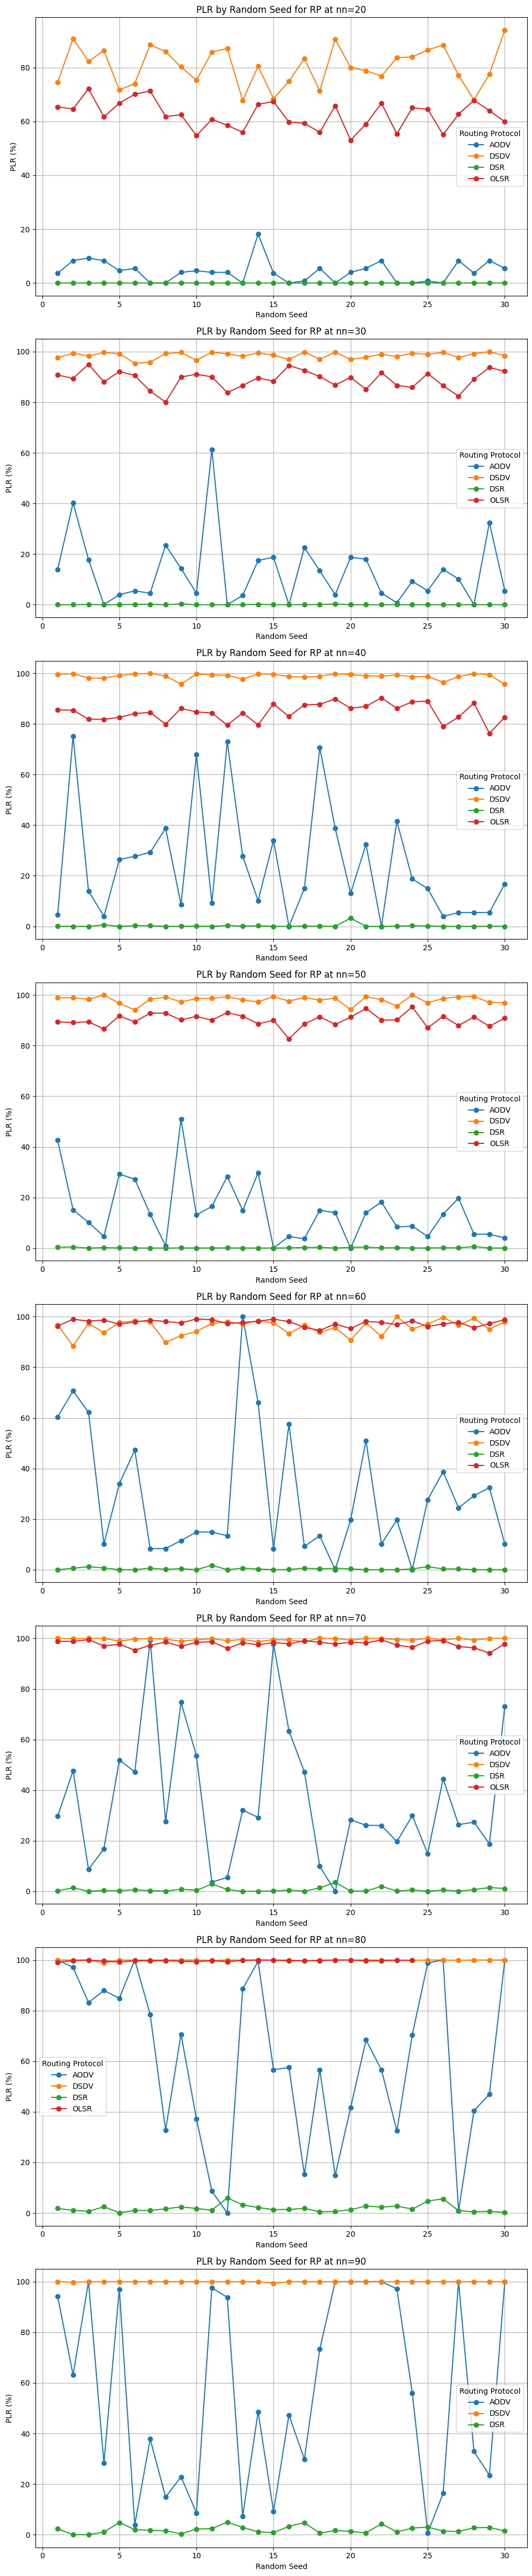

In [14]:
# Function to parse a single line of data
def parse_line(line):
    parts = line.split(', ')
    if len(parts) < 5:
        return None
    rp = parts[0].split(' ')[1]
    nn = int(parts[1].split(' ')[1])
    random_seed = int(parts[2].split(' ')[2])
    plr = float(parts[4].split(' ')[1][:-1])
    return {"rp": rp, "nn": nn, "random_seed": random_seed, "PLR": plr}

# Read and parse the file
data = []
#with open('results-fanet-3d-20-to-50-aodv-dsr-dsdv.txt', 'r') as file:
# with open('results-fanet-3d-total-aodv-dsr-dsdv.txt', 'r') as file:
#with open('results-fanet-3d-olsr-20-to-80nodes.txt', 'r') as file:
with open('results-fanet-total.txt', 'r') as file:
    for line in file:
        parsed_line = parse_line(line.strip())
        if parsed_line:
            data.append(parsed_line)

# Assuming 'data' is your list of dictionaries containing the parsed file data
df = pd.DataFrame(data)

# Count the number of unique 'nn' values to determine the number of subplots needed
unique_nn_values = df['nn'].unique()
num_subplots = len(unique_nn_values)

# Create subplots based on the number of unique 'nn' values
fig, axs = plt.subplots(num_subplots, 1, figsize=(10, 6 * num_subplots), squeeze=False)

# If there's only one unique 'nn' value, axs will not be an array of arrays. Fix that:
if num_subplots == 1:
    axs = [axs]

# Iterate over each unique 'nn' value to plot the corresponding data
for idx, nn in enumerate(unique_nn_values):
    nn_df = df[df['nn'] == nn]
    for rp, rp_grp in nn_df.groupby('rp'):
        axs[idx][0].plot(rp_grp['random_seed'], rp_grp['PLR'], '-o', label=rp)
    axs[idx][0].set_title(f'PLR by Random Seed for RP at nn={nn}')
    axs[idx][0].set_xlabel('Random Seed')
    axs[idx][0].set_ylabel('PLR (%)')
    axs[idx][0].legend(title='Routing Protocol')
    axs[idx][0].grid(True)

plt.tight_layout()
plt.show()



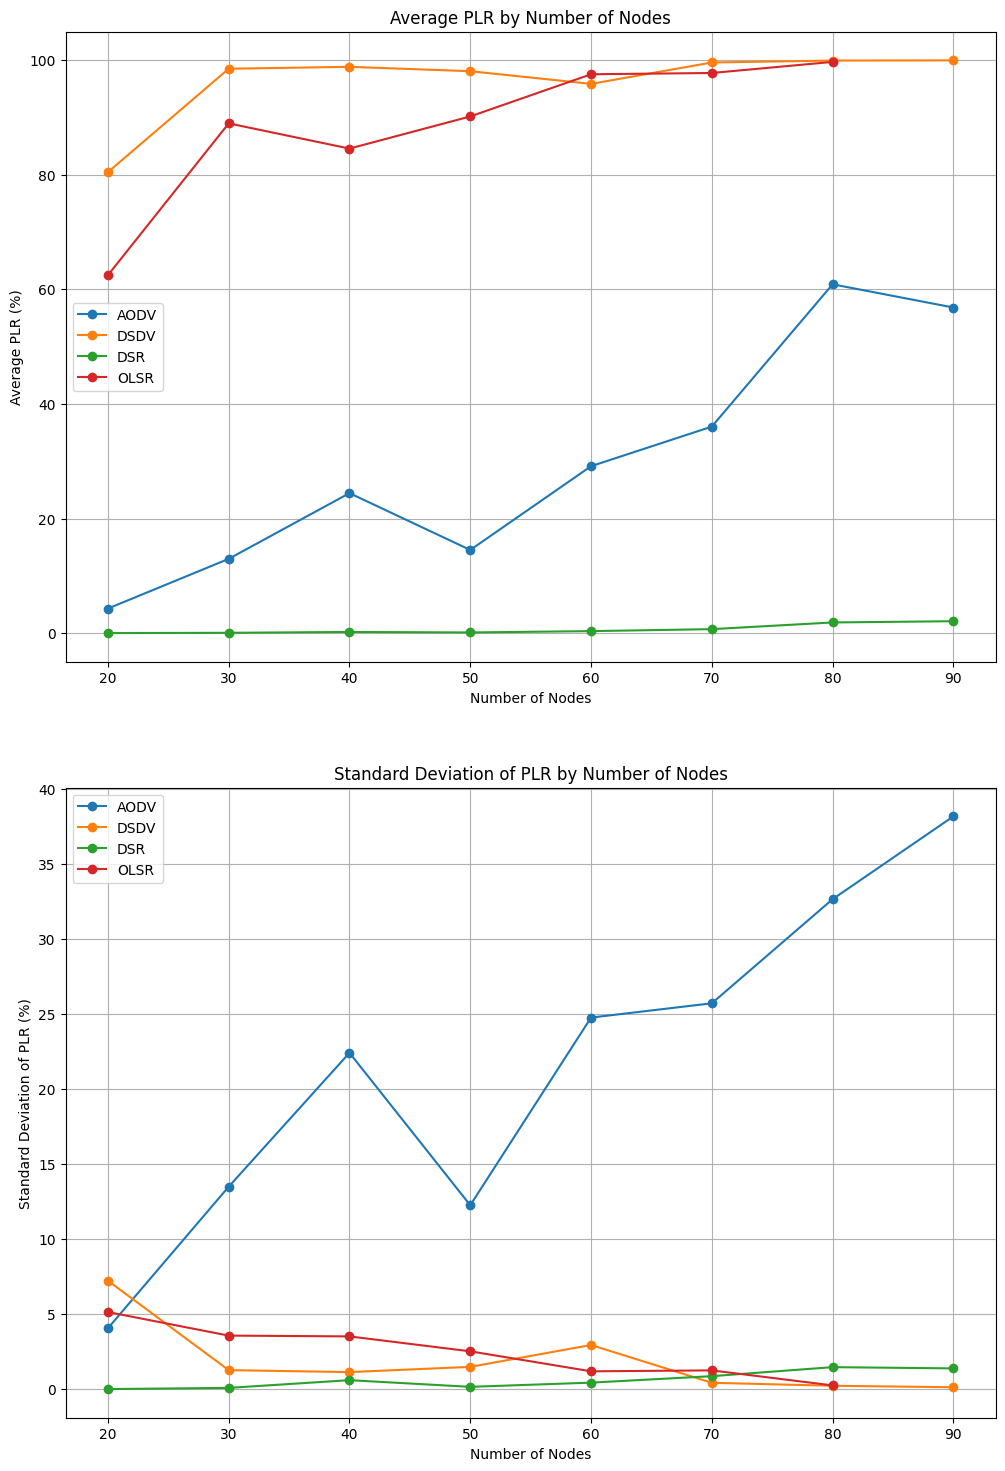

In [15]:
# 1. Calculate Statistics
stats_df = df.groupby(['rp', 'nn'])['PLR'].agg(['mean', 'std', 'min', 
                                                ('25%', lambda x: x.quantile(0.25)), 
                                                'median', 
                                                ('75%', lambda x: x.quantile(0.75)), 
                                                'max']).reset_index()

# 2. Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 18))

# Plot for Average PLR
for rp in stats_df['rp'].unique():
    rp_df = stats_df[stats_df['rp'] == rp]
    axs[0].plot(rp_df['nn'], rp_df['mean'], '-o', label=rp)
axs[0].set_title('Average PLR by Number of Nodes')
axs[0].set_xlabel('Number of Nodes')
axs[0].set_ylabel('Average PLR (%)')
axs[0].legend()
axs[0].grid(True)

# Plot for Standard Deviation of PLR
for rp in stats_df['rp'].unique():
    rp_df = stats_df[stats_df['rp'] == rp]
    axs[1].plot(rp_df['nn'], rp_df['std'], '-o', label=rp)
axs[1].set_title('Standard Deviation of PLR by Number of Nodes')
axs[1].set_xlabel('Number of Nodes')
axs[1].set_ylabel('Standard Deviation of PLR (%)')
axs[1].legend()
axs[1].grid(True)


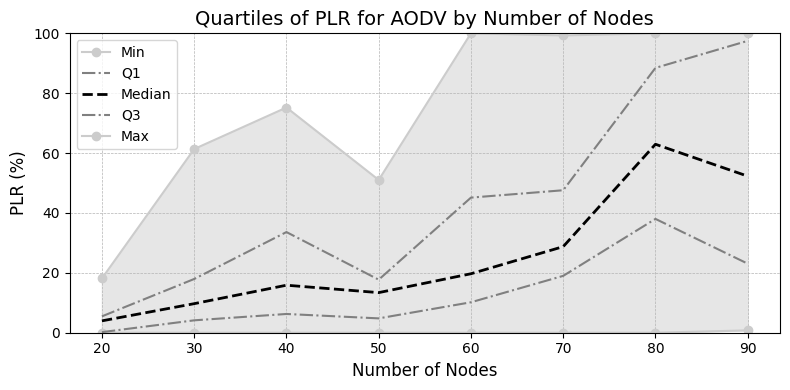

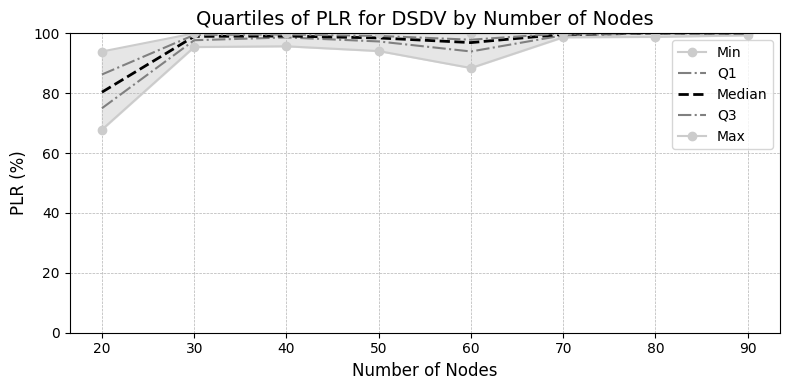

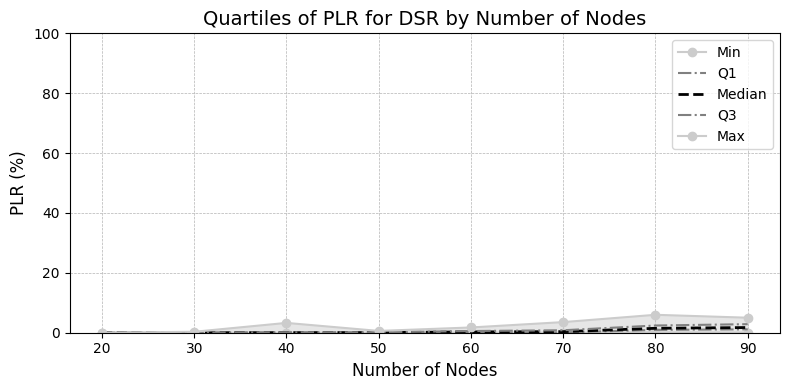

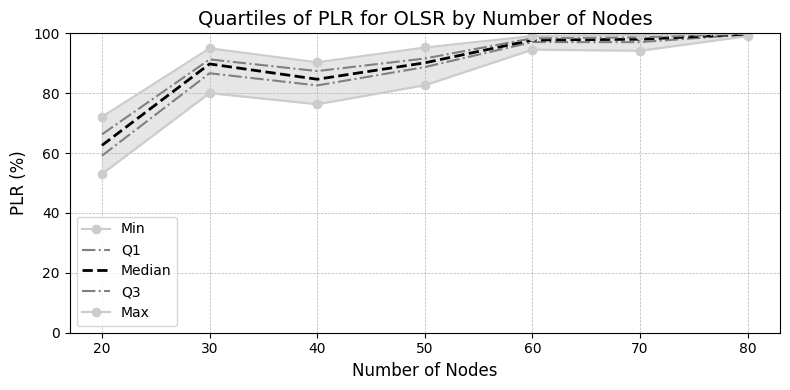

In [16]:
# Unique routing protocols
rps = stats_df['rp'].unique()

# Number of routing protocols
num_rps = len(rps)

# Create a figure for each routing protocol
for rp in rps:
    fig, ax = plt.subplots(figsize=(8, 4))
    rp_df = stats_df[stats_df['rp'] == rp]
    
    # Defining grayscale colors
    color_min_max = '0.8'  # Light gray for Min and Max lines
    color_quartiles = '0.5'  # Darker gray for Q1 and Q3 lines
    color_median = '0.0'  # Black for the Median line

    # Filling the background between min and max without 'step', for a smooth transition
    ax.fill_between(rp_df['nn'], rp_df['min'], rp_df['max'], color='0.9')

    # Plotting quartile lines
    ax.plot(rp_df['nn'], rp_df['min'], '-o', color=color_min_max, label='Min')
    ax.plot(rp_df['nn'], rp_df['25%'], '-.', color=color_quartiles, label='Q1')
    ax.plot(rp_df['nn'], rp_df['median'], '--', color=color_median, label='Median', linewidth=2)  # Making median line bold
    ax.plot(rp_df['nn'], rp_df['75%'], '-.', color=color_quartiles, label='Q3')
    ax.plot(rp_df['nn'], rp_df['max'], '-o', color=color_min_max, label='Max')
    
    # Set Y-axis limits
    ax.set_ylim(0, 100)
    
    # Setting titles, labels, and grid
    ax.set_title(f'Quartiles of PLR for {rp} by Number of Nodes', fontsize=14)
    ax.set_xlabel('Number of Nodes', fontsize=12)
    ax.set_ylabel('PLR (%)', fontsize=12)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='0.7')

    plt.tight_layout()
    plt.show()

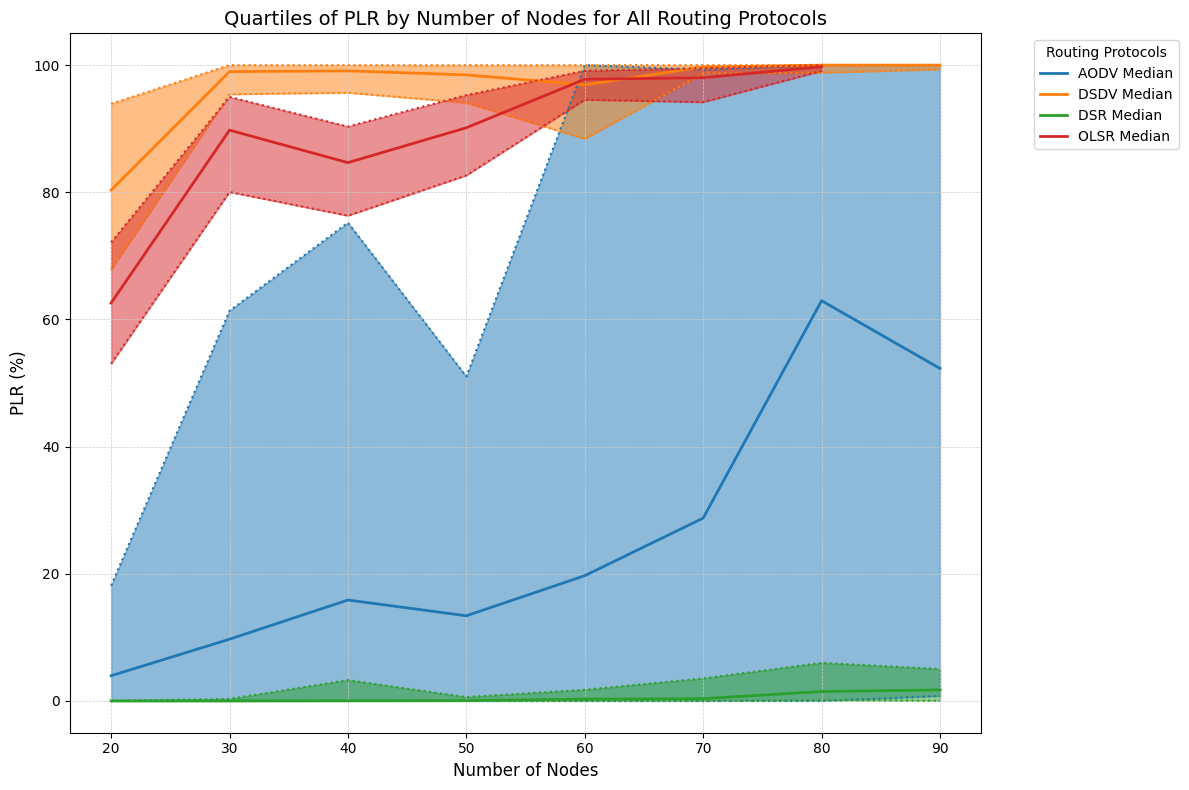

In [17]:

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Defining a list of distinct colors for differentiation between protocols
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
if len(rps) > len(colors):  # Ensure there are enough colors
    colors = colors * (len(rps) // len(colors) + 1)

for idx, rp in enumerate(rps):
    rp_df = stats_df[stats_df['rp'] == rp]

    # Using distinct colors
    color = colors[idx % len(colors)]

    # Filling the background between min and max with a very light gray to keep the focus on the colored lines
    ax.fill_between(rp_df['nn'], rp_df['min'], rp_df['max'], color=color, alpha=0.5)

    # Plotting each quartile with specified colors
    ax.plot(rp_df['nn'], rp_df['min'], label=f'{rp} Min', color=color, linestyle='dotted')
    ax.plot(rp_df['nn'], rp_df['median'], label=f'{rp} Median', color=color, linestyle='solid', linewidth=2)
    ax.plot(rp_df['nn'], rp_df['max'], label=f'{rp} Max', color=color, linestyle='dotted')

# Setting titles and labels
ax.set_title('Quartiles of PLR by Number of Nodes for All Routing Protocols', fontsize=14)
ax.set_xlabel('Number of Nodes', fontsize=12)
ax.set_ylabel('PLR (%)', fontsize=12)

# Enhancing the legend
handles, labels = ax.get_legend_handles_labels()
# Creating a legend that includes one entry per routing protocol
legend_labels = {label: handle for handle, label in zip(handles, labels) if 'Median' in label} 
ax.legend(legend_labels.values(), legend_labels.keys(), title="Routing Protocols", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='0.8')
plt.tight_layout()
plt.show()

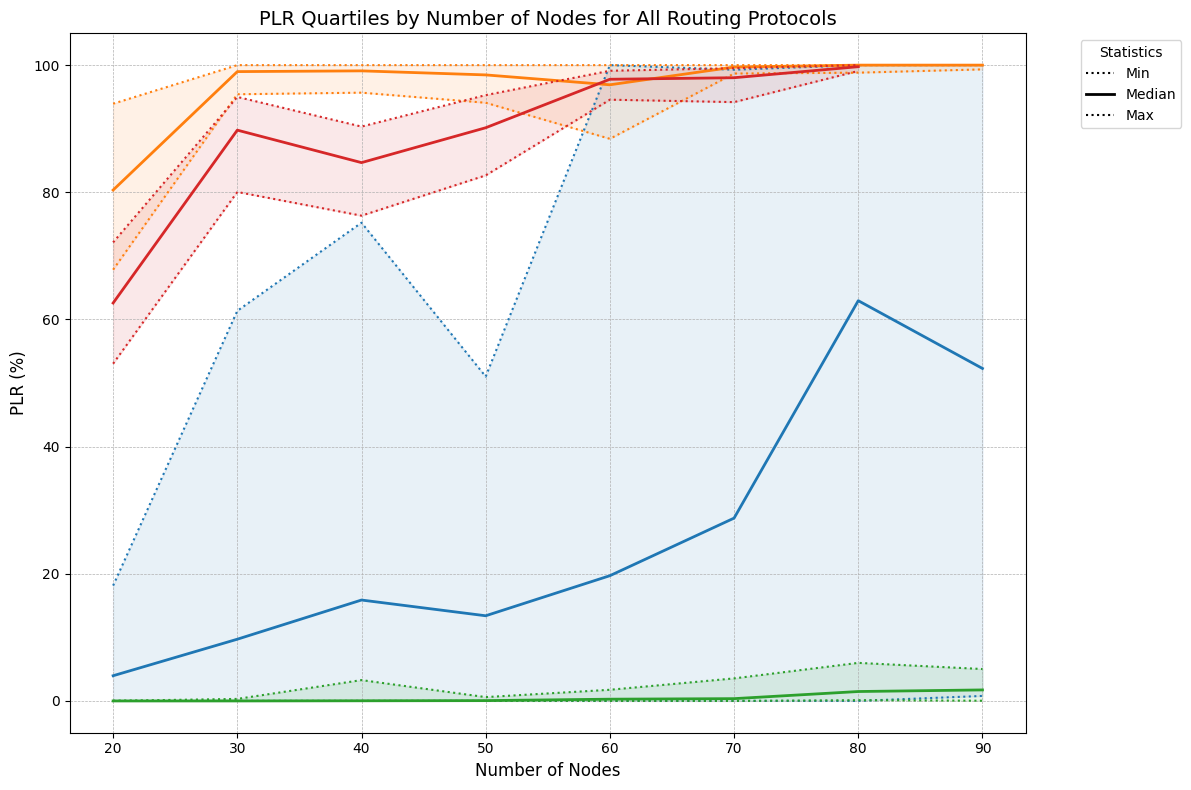

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

for idx, rp in enumerate(rps):
    # Filtering the DataFrame for each routing protocol
    rp_df = stats_df[stats_df['rp'] == rp]
    color = colors[idx % len(colors)]  # Cycling through colors
    
    # Plot min, median, max with specific aesthetics
    ax.plot(rp_df['nn'], rp_df['min'], label=f'{rp} Min', color=color, linestyle='dotted')
    ax.plot(rp_df['nn'], rp_df['median'], label=f'{rp} Median', color=color, linestyle='solid', linewidth=2)
    ax.plot(rp_df['nn'], rp_df['max'], label=f'{rp} Max', color=color, linestyle='dotted')
    
    # Filling between min and max
    ax.fill_between(rp_df['nn'], rp_df['min'], rp_df['max'], color=color, alpha=0.1)

# Setting plot titles and labels
ax.set_title('PLR Quartiles by Number of Nodes for All Routing Protocols', fontsize=14)
ax.set_xlabel('Number of Nodes', fontsize=12)
ax.set_ylabel('PLR (%)', fontsize=12)

# Simplifying the legend to include only one set of Min, Median, Max per protocol
# Creating a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='dotted', label='Min'),
                Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='Median'),
                Line2D([0], [0], color='black', linestyle='dotted', label='Max')]

# Add a legend outside the plot
ax.legend(handles=custom_lines, title="Statistics", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()